In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.2 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from glob import glob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

root_dir = "/Users/trevorwiebe/Ktor/radar_backend/radar_data/"

In [4]:
# Setting device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv(sorted(glob(root_dir + 'csv_files/*.csv'))[0])

# Get unique latitudes and longitudes
unique_latitudes = df['latitude'].unique().size
unique_longitudes = df['longitude'].unique().size

In [6]:
# Load CSV files
csv_files = sorted(glob(root_dir + 'csv_files/*.csv'))

def csv_to_grid(file_path):
    df = pd.read_csv(file_path)

    # Replace 'unknown' values that are 15 or smaller with 0
    df['unknown'] = df['unknown'].apply(lambda x: max(x, 0) if x > 15 else 0)
    
    # Ensure your radar data has the correct latitude/longitude ranges.
    grid = df.pivot(index='latitude', columns='longitude', values='unknown').values
    
    # Check if the grid has the correct shape (1018, 1018)
    if grid.shape != (unique_latitudes, unique_longitudes):
        raise ValueError(f"Grid shape mismatch in file {file_path}. Expected ({unique_latitudes}, {unique_longitudes}), got {grid.shape}")
    
    return grid

In [7]:
# Create input sequences and target sequences
sequence_length = 30 # e.g., number of csv files to look back on
prediction_horizon = 30 # number of csv files to predict
height, width = unique_latitudes, unique_longitudes

# Create 5D tensors for input and output, adding a channel dimension
X = []
y = []

print(len(csv_files) - sequence_length - prediction_horizon + 1)
for i in range(len(csv_files) - sequence_length - prediction_horizon + 1):
    print(i)
    input_sequence = [csv_to_grid(csv_files[j]) for j in range(i, i + sequence_length)]
    output_sequence = [csv_to_grid(csv_files[j]) for j in range(i + sequence_length, i + sequence_length + prediction_horizon)]
    
    # Reshape input and output sequences to add a channel dimension (reflectivity as 1 channel)
    input_sequence = np.array(input_sequence).reshape(sequence_length, height, width, 1)  # (sequence_length, height, width, 1)
    output_sequence = np.array(output_sequence).reshape(prediction_horizon, height, width, 1)  # (prediction_horizon, height, width, 1)
    
    X.append(input_sequence)
    y.append(output_sequence)

train_set= np.array(X)  # shape: (num_samples, sequence_length, height, width, 1)
val_set = np.array(y)  # shape: (num_samples, prediction_horizon, height, width, 1)

train_dataset = train_set / 255
val_dataset = val_set / 255

10
0
1
2
3
4
5
6
7
8
9


Frame 22 is the same as the previous frame.
Displaying frames for example 3.


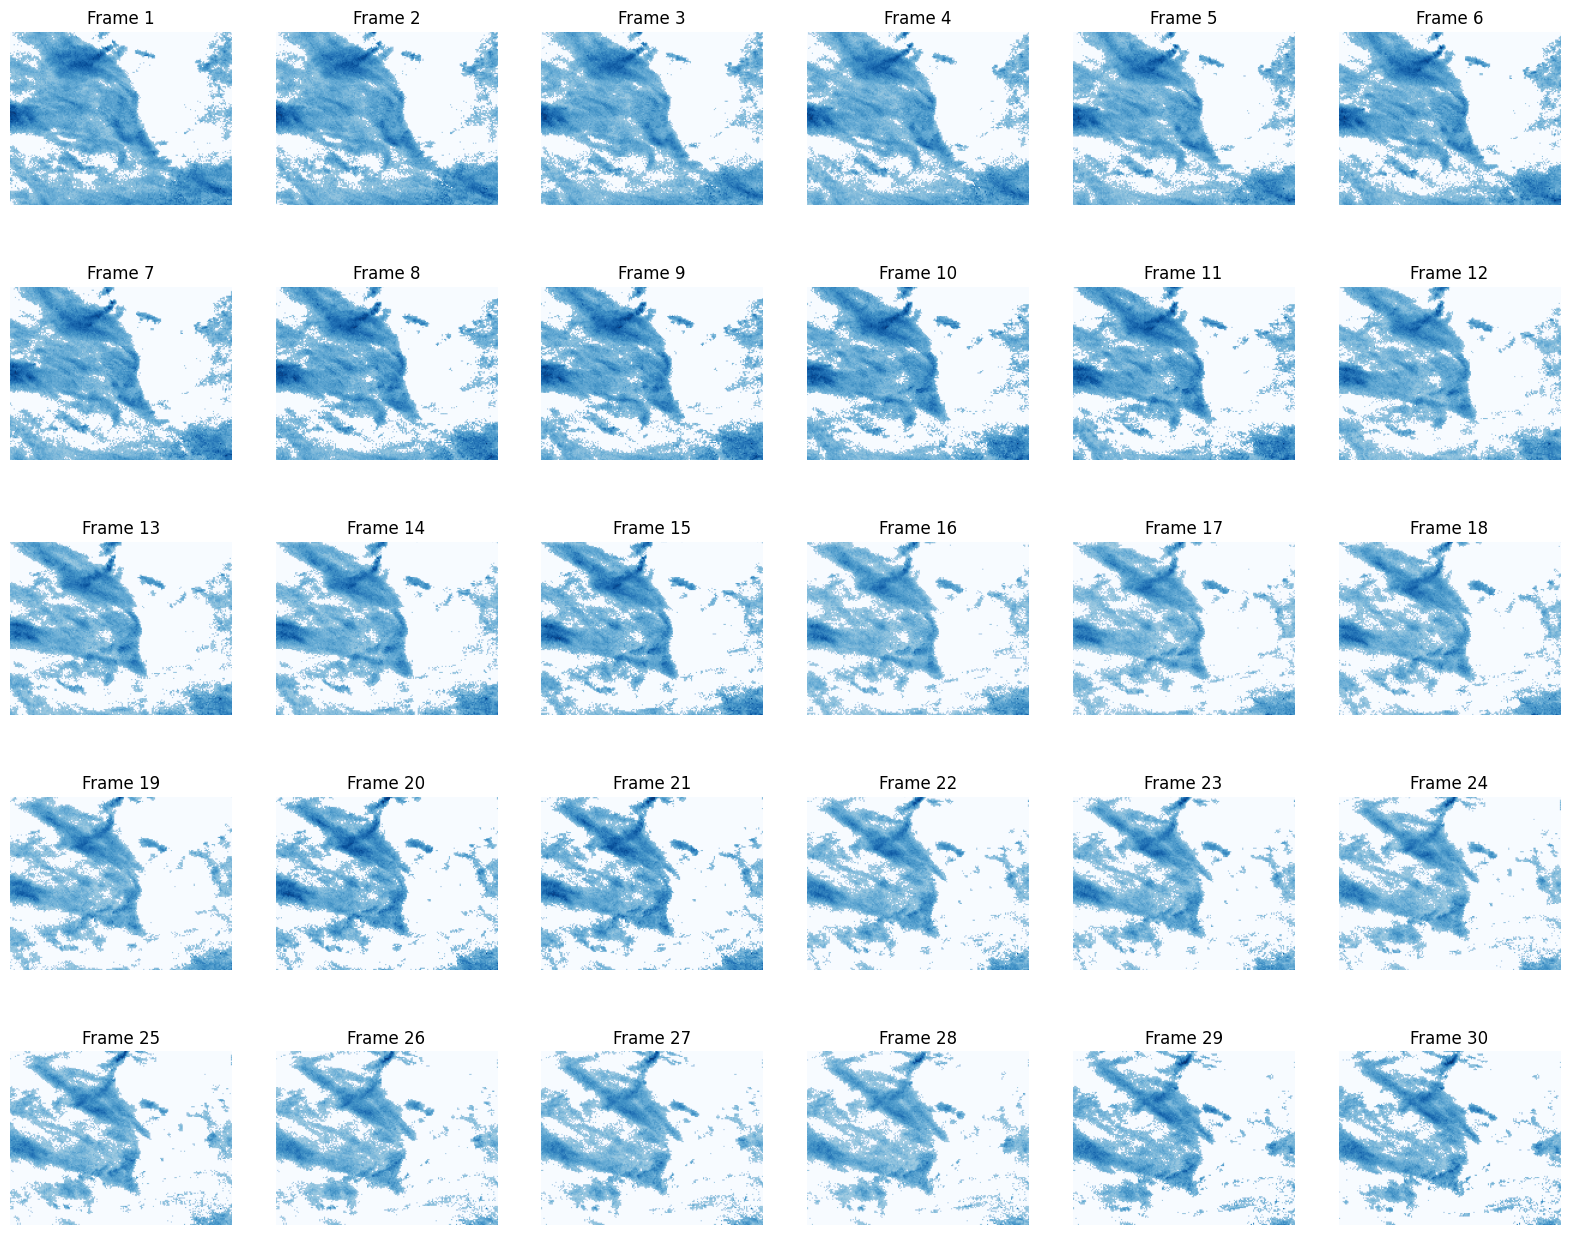

In [8]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(5, 6, figsize=(20, 16))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_set)), size=1)[0]
lastdata = None  # Initialize lastdata to None before looping

for idx, ax in enumerate(axes.flat):
    thisdata = train_set[data_choice][idx]
    
    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(thisdata, lastdata):
        print(f"Frame {idx} is the same as the previous frame.")
    
    # Display the image
    ax.imshow(np.squeeze(thisdata), cmap="Blues")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    
    # Update lastdata
    lastdata = thisdata

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input

channels = 1  # Reflectivity is your feature, so 1 channel

# Define the model using an Input layer for the input shape
model = Sequential()

# Add Input Layer
model.add(Input(shape=(sequence_length, height, width, channels))) 

# First ConvLSTM2D layer with return_sequences=True
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
model.add(BatchNormalization())

# Second ConvLSTM2D layer with return_sequences=True to return all frames
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
model.add(BatchNormalization())

# Replace Conv3D with Conv2D to predict the next frame(s)
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same'))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 30, 145, 185,   │       150,016 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 145, 185,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 30, 145, 185,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 145, 185,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 30, 145, 185,   │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,425 (1.71 MB)

 Trainable params: 447,169 (1.71 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
# Train the model
model.fit(train_dataset, val_dataset, batch_size=16, epochs=20)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 145s 145s/step - loss: 1.1602
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 137s 137s/step - loss: 5.6332
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 136s 136s/step - loss: 0.6153
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 125s 125s/step - loss: 0.5555
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 0.1541
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 131s 131s/step - loss: 0.0755
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 126s 126s/step - loss: 0.0739
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 0.0798
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 124s 124s/step - loss: 0.0518
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 0.0373
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 831s 831s/step - loss: 0.0465
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 151s 151s/step - loss: 0.0461
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 127s 127s/step - loss: 0.0321
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 127s 127s/step - loss: 0.0302
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 0.0338
Epoc